<font color='red'>**Ciclo 7**</font>

**ENTENDER O PROBLEMA**

- Objetivo do Problema:
    - Previsão do primeiro destino que um novo usuario ira escolher.
    
    - Porque?
        - Qual o tipo de modelo de negocio do Airbnb?
        
            - Marketplace ( Conecta pessoas que oferecem acomodação, com pessoas que estão procurando acomodação )
            - Oferta ( pessoas oferecendo acomodação )
                - Tamanho do portfólio.
                - Diversidade/Densidade de Portifolio.
                - Preco Medio
                
            - Demanda ( pessoas procurando acomodação )
                - Numero de usuario
                - LTV ( Lifetime Value )
                - CAC ( Client Acquisition Cost )
                
                <font color='red'>**Receita Bruta**</font> =  ( Taxa*NúmeroDeClientes ) - CAC

             
             
- Proposta de Solução
    - Modelo de Previsão do primeiro destino de um novo usuario.
        - Predicoes e salva em uma tabela do banco de dados.
        - API
            - Input: Usuario e suas caracteristicas.
            - Output: Usuario e suas caracteristicas com a **predicao de destino** 
            

- Total de Ciclos ( CRISPM ):
    - 16 ciclos.
    

# IMPORTS

In [137]:
import pandas as pd
import numpy  as np

import matplotlib.pyplot as plt
import seaborn           as sns

from sklearn    import model_selection as ms
from sklearn    import preprocessing   as pp
from sklearn    import metrics         as m
from keras      import models          as ml
from keras      import layers          as l
from scikitplot import metrics         as mt
from scipy      import stats           as ss

from imblearn   import under_sampling  as us
from imblearn   import over_sampling   as oversamp
from imblearn   import combine         as c

from pandas_profiling import ProfileReport

from IPython.display       import Image
from IPython.core.display  import HTML

import random

import warnings
warnings.filterwarnings('ignore')

## Helper Functions

In [138]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Loading Data

In [5]:
df_raw = pd.read_csv('./data/training_users.csv', low_memory=True)
df_raw.shape

(213451, 16)

In [6]:
df_sessions = pd.read_csv('./data/sessions.csv', low_memory=True)
df_sessions.shape

#df_sessions[df_sessions['user_id'] == "00023iyk9l"][['user_id', 'action']].groupby('user_id').value_counts()

(10567737, 6)

# DATA DESCRIPTION

In [7]:
df1 = df_raw
df1.shape

(213451, 16)

## Data Dimensions 

In [8]:
print(f'number of rows: {df1.shape[0]}')
print(f'number of columns: {df1.shape[1]}')

number of rows: 213451
number of columns: 16


In [9]:
print(f'number of rows: {df_sessions.shape[0]}')
print(f'number of columns: {df_sessions.shape[1]}')

number of rows: 10567737
number of columns: 6


## Data Types

In [10]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [11]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## NA Check

In [12]:
df1.isna().sum() / len(df1)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [13]:
df_sessions.isna().sum() / len(df_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

In [14]:
# ================ Users ====================

# date_first_booking
date_first_booking_max = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)

# age
df1 = df1[(df1['age'] > 15) & (df1['age'] < 120)]
avg_age = age = df1['age'].mean().astype(int)
df1['age'] = df1['age'].fillna(avg_age)

# first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

# ================ Sessions ====================

# user_id - 0.3%
df_sessions = df_sessions[~df_sessions['user_id'].isna()]


# action - 0.7%
df_sessions = df_sessions[~df_sessions['action'].isna()]


# action_type - 11%
df_sessions = df_sessions[~df_sessions['action_type'].isna()]


# action_detail - 11%
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]


# secs_elapsed - 1.2%
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]


## Change Data Type

In [15]:
# date_account_created
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

# date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])

# age
df1['age'] = df1['age'].astype(int)

In [16]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## Check Balanced Data

In [17]:
df1['country_destination'].value_counts(normalize=True)

NDF      0.447275
US       0.391867
other    0.061246
FR       0.029918
IT       0.016423
GB       0.014335
ES       0.013740
CA       0.008676
DE       0.006858
NL       0.004852
AU       0.003531
PT       0.001280
Name: country_destination, dtype: float64

## Descriptive Analysis

## General

In [18]:
# users
num_attrs = df1.select_dtypes(include=['int64', 'float64'])
cat_attrs = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attrs = df1.select_dtypes(include=['datetime64[ns]'])

# sessions
num_attrs_sessions = df_sessions.select_dtypes(include=['int64', 'float64'])
cat_attrs_sessions = df_sessions.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attrs_sessions = df_sessions.select_dtypes(include=['datetime64[ns]'])

### Numerical - Users

In [19]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attrs.apply(np.mean)).T
ct2 = pd.DataFrame(num_attrs.apply(np.median)).T

# dispersions - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attrs.apply(np.std)).T
d2 = pd.DataFrame(num_attrs.apply(min)).T
d3 = pd.DataFrame(num_attrs.apply(max)).T
d4 = pd.DataFrame(num_attrs.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attrs.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attrs.apply(lambda x: x.kurtosis())).T

# concat
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,16.0,115.0,99.0,37.405591,34.0,13.939844,2.089718,6.516468
1,signup_flow,0.0,25.0,25.0,2.519513,0.0,6.604696,2.705871,5.928298


### Numerical - Sessions

In [20]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attrs_sessions.apply(np.mean)).T
ct2 = pd.DataFrame(num_attrs_sessions.apply(np.median)).T

# dispersions - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attrs_sessions.apply(np.std)).T
d2 = pd.DataFrame(num_attrs_sessions.apply(min)).T
d3 = pd.DataFrame(num_attrs_sessions.apply(max)).T
d4 = pd.DataFrame(num_attrs_sessions.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attrs_sessions.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attrs_sessions.apply(lambda x: x.kurtosis())).T

# concat
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### Categorical - Users

In [21]:
cat_attrs.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


### Categorical - Sessions

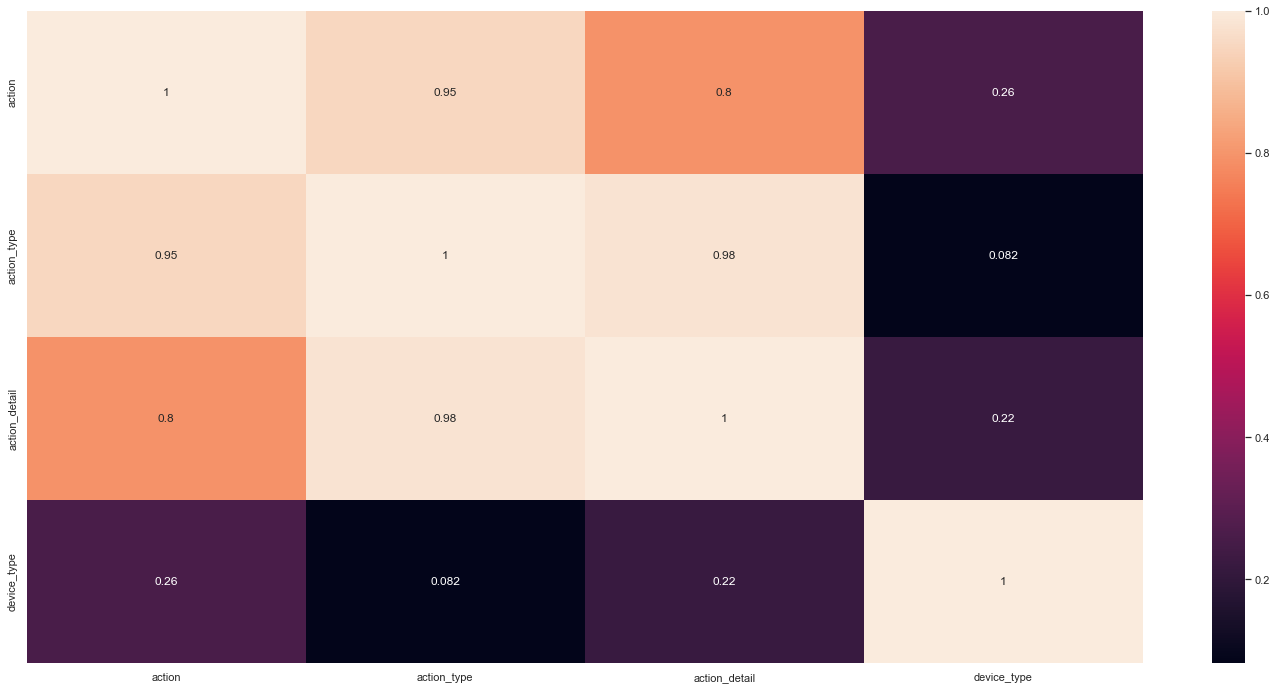

In [22]:
cat_attrs_sessions_list = cat_attrs_sessions.drop('user_id', axis=1).columns.tolist()

corr_dict = {}
for i in range(len(cat_attrs_sessions_list)):
    corr_list = []
    for j in range(len(cat_attrs_sessions_list)):
        
        ref = cat_attrs_sessions_list[i]
        feat = cat_attrs_sessions_list[j]
        
        # correlation
        corr = cramer_v(cat_attrs_sessions[ ref ], cat_attrs_sessions[ feat ])
        
        # append a list
        corr_list.append(corr)
        
    # append a correlation list for each ref attrs
    corr_dict[ref] = corr_list
    
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True);

# FEATURE ENGINEERING

In [93]:
df2 = df1.copy()
df2.shape

(122636, 16)

## Create New Features

In [117]:
# days from first active up to frist booking
df2['first_active'] = pd.to_datetime(df2['timestamp_first_active'].dt.strftime('%Y-%m-%d'))
df2['days_from_first_active_until_booking'] = (df2['date_first_booking'] - df2['first_active']).apply(lambda x: x.days)

# days from first active up to account created
df2['days_from_first_active_until_account_created'] = (df2['date_account_created'] - df2['first_active']).apply(lambda x: x.days)

# days from account created up to first booking
df2['days_from_account_created_until_first_booking'] = (df2['date_first_booking'] - df2['date_account_created']).apply(lambda x: x.days)


# ========================== First Active ==========================


# year first active - ok
df2['year_first_active'] = df2['first_active'].dt.year

# month first active - ok
df2['month_first_active'] = df2['first_active'].dt.month

# day of first active - ok
df2['day_first_active'] = df2['first_active'].dt.day

# day of week first active - ok
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek

# week of year first active - ok
df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear


# ========================== First Booking ==========================

# year first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year

# month first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month

# day of first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day

# day of week first booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

# week of year first booking
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear

# ========================== First Account Created ==========================
 
# year first account created
df2['year_account_created'] = df2['date_account_created'].dt.year

# month first booking
df2['month_account_created'] = df2['date_account_created'].dt.month

# day of first booking
df2['day_account_created'] = df2['date_account_created'].dt.day

# day of week first booking
df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek

# week of year first booking
df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear


# DATA FILTERING

In [118]:
df3 = df2.copy()
df3.shape

(122636, 36)

## Filtering Rows

In [119]:
# df3 = df3[(df3['age'] > 15) & (df3['age'] < 120)]

# df3 = df3[df3[''] > 0]


## Columns Selection

In [120]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'first_active'] # origial dates

df3 = df3.drop(cols_drop, axis=1)

# BALANCED DATASET

In [121]:
df4 = df3.copy()

In [122]:
# Encoder Categorical Variables
ohe = pp.OneHotEncoder()

# Numerical
col_num = df4.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Categorical
col_cat = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).drop(['id', 'country_destination'], axis=1).columns.tolist()

# encoding
df4_dummy = pd.DataFrame(ohe.fit_transform(df4[col_cat]).toarray(), index=df4.index)

# join numerical and categorical
df42 = pd.concat([df4[col_num], df4_dummy], axis=1)

## Random Undersampling

In [123]:
# ration balanced
ratio_balanced = {'NDF': 10000}

# define Sampler
undersampling = us.RandomUnderSampler(sampling_strategy=ratio_balanced, random_state=32)

# apply sampler
x_under, y_under = undersampling.fit_resample(df42, df4['country_destination'])

In [124]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [125]:
y_under.value_counts()

US       48057
NDF      10000
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

## Random Oversampling

In [126]:
# define Sampler
oversampling = oversamp.RandomOverSampler(sampling_strategy='all', random_state=32)

# apply sampler
x_over, y_over = oversampling.fit_resample(df42, df4['country_destination'])

In [127]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [128]:
y_over.value_counts()

NDF      54852
US       54852
other    54852
CA       54852
FR       54852
IT       54852
ES       54852
GB       54852
NL       54852
DE       54852
AU       54852
PT       54852
Name: country_destination, dtype: int64

## SMOTE + TOMELINK

In [129]:
ratio_balanced = {
    
    'NDF': 54852,
    'US': 48057,
    'other': 6*7511,
    'FR': 12*3669,
    'IT': 20*2014,
    'GB': 30*1758,
    'ES': 30*1685,
    'CA': 40*1064,
    'DE': 45*841,
    'NL': 80*595,
    'AU': 85*433,
    'PT': 300*157
}

<font color='red'>**ARRUMAR ACCOUNTED CREATED**</font>

In [130]:
# # define sampler
# smt = c.SMOTETomek(sampling_strategy=ratio_balanced, random_state=32, n_jobs=1)

# # apply sampler
# x_smt, y_smt = smt.fit_resample(df42, df4['country_destination'])

# # numerical data
# df43 = x_smt[col_num]

# # =-=-=-=-==-=-=-=-==-=-=-=-==-=-=-=-==-=-=-=-==-=-=-=-==-=-=-=-==-=-=-=-==-=-=-=-==-=-=-=-=

# # categorical data
# df44 = x_smt.drop(col_num, axis=1)
# df45 = pd.DataFrame(ohe.inverse_transform(df44), columns=col_cat, index=df44.index)

# # join numerical categorical
# df46 = pd.concat([df43, df45], axis=1)
# df46['country_destination'] = y_smt

# df46.to_csv('./data/df46.csv', index=False)

# =-=-=-=-==-=-=-=-==-=-=-=-==-=-=-=-==-=-=-=-==-=-=-=-==-=-=-=-==-=-=-=-==-=-=-=-==-=-=-=-=

df46 = pd.read_csv('./data/df46.csv')

# EXPLORATORY DATA ANALYSIS

In [131]:
df51 = df46.copy()

In [132]:
df52 = df4.copy()

## Hypothesis Validation (Unbalanced Dataset)

**H01**. Em todos os destinos, os usuarios levam 15 dias, em media, para fazer a primeira reserva no AirBnB, desde sua primeira ativação.

**VERDADEIRO**. Em todos os destinos os usuarios levam até 6 dias para reservar.

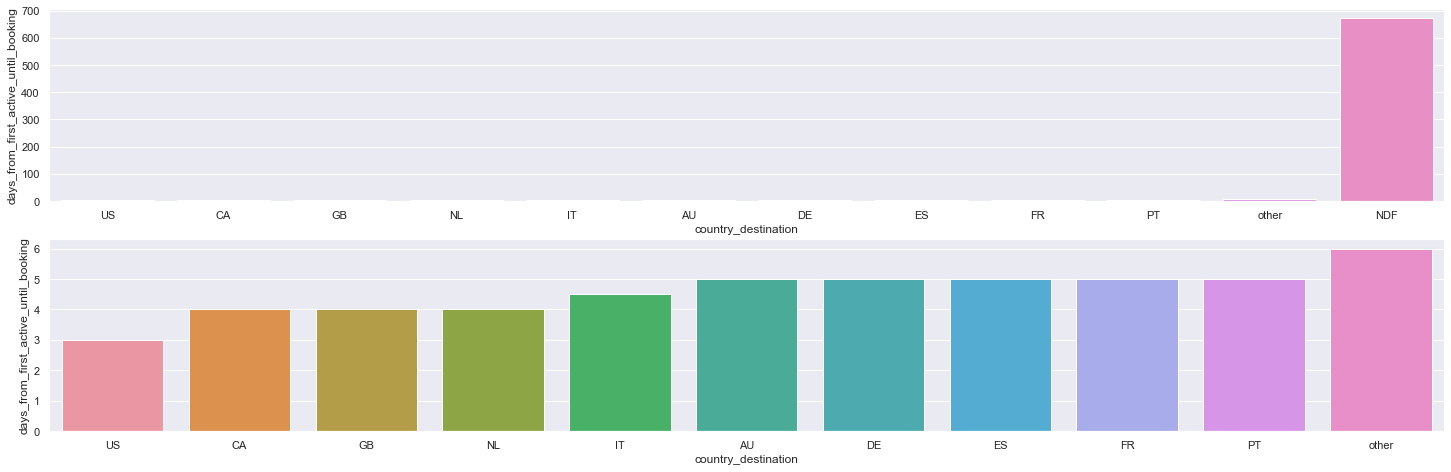

In [88]:
plt.subplot(3, 1, 1)

aux01 = df52[['days_from_first_active_until_booking', 'country_destination']].groupby('country_destination').median().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_until_booking', data=aux01.sort_values('days_from_first_active_until_booking'));

# remove outlier

plt.subplot(3, 1, 2)

aux02 = df52[df52['country_destination'] != 'NDF']
aux02 = aux02[['days_from_first_active_until_booking', 'country_destination']].groupby('country_destination').median().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_until_booking', data=aux02.sort_values('days_from_first_active_until_booking'));

**H02**. Em todos os destinos, os usuarios levam 3 dias em media para fazer o cadastro no site

**VERDADEIRA** Em todos os destinos os usuarios levam até 2 dias para finalizar o cadastro.

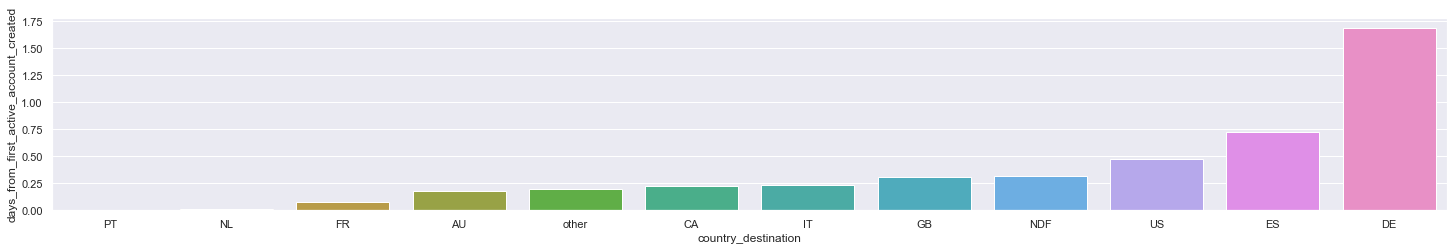

In [136]:
plt.subplot(3, 1, 1)

aux01 = df52[['days_from_first_active_account_created', 'country_destination']].groupby('country_destination').mean().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_account_created', data=aux01.sort_values('days_from_first_active_account_created'));

**H03**. O volume de reservas anual feitas durante o verão aumentaram 20% para destinos dentro dos USA.

**FALSA** O Volume de reservas aumentam durante o verao entre os anos de 2010 até 2013.

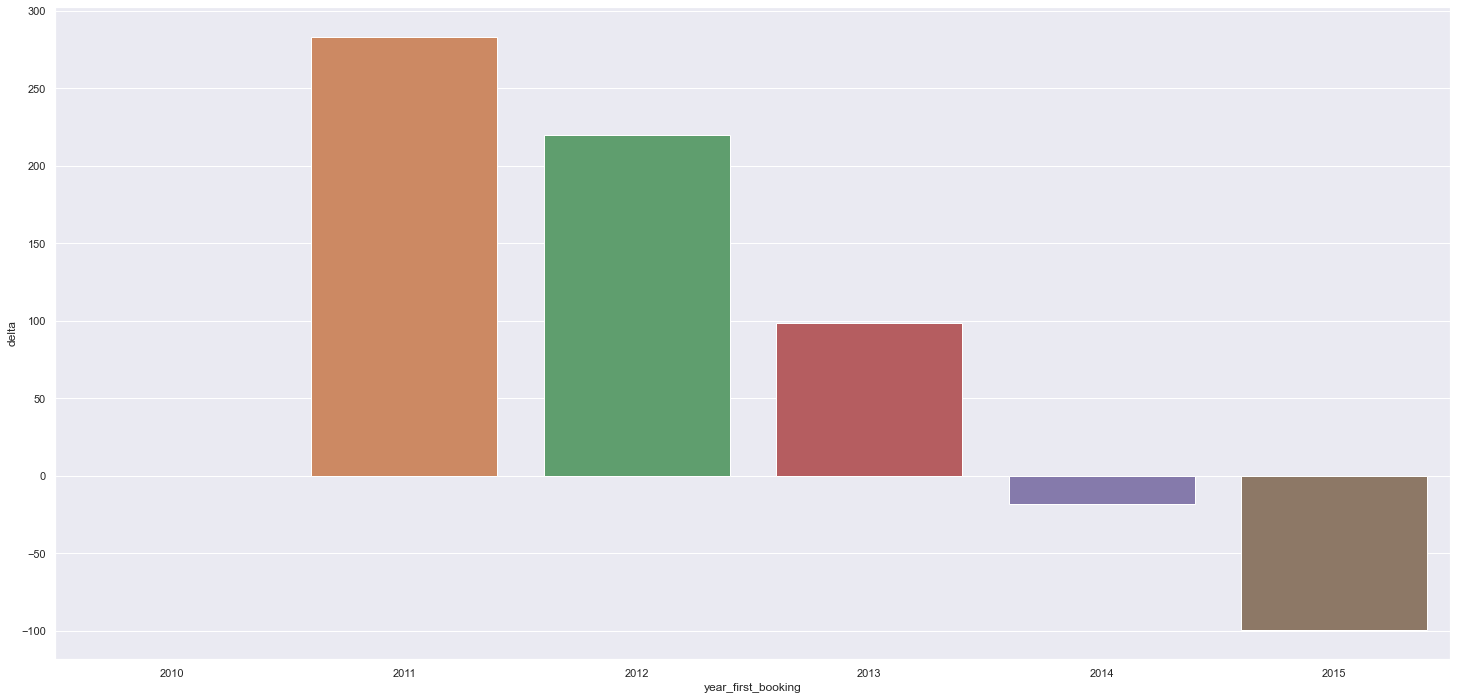

In [157]:
aux01 = df52[['year_first_booking','month_first_booking','country_destination']]\
.groupby(['year_first_booking','month_first_booking','country_destination']).size().reset_index().rename(columns={0:'count'})

# select only summer
aux01 = aux01[(aux01['month_first_booking'].isin([6, 7, 8, 9]) & (aux01['country_destination'] == 'US'))]

aux02 = aux01[['year_first_booking', 'count']].groupby('year_first_booking').sum().reset_index()
aux02['delta'] = 100*aux02['count'].pct_change().fillna(0)

sns.barplot(x='year_first_booking', y='delta', data=aux02);

**H04**. Usuarios do sexo feminino fazem 10% mais reservas para paises fora dos USA,

**H05**. O canal de marketing Google representa 40% das reservas para paises fora dos USA.

**H06**. O destino dos USA representam mais de 20% em todos os canais.

**H07**. A idade media das pessoas é de 35 anos em todos os destinos

**H08**. A porcentagem de usuarios que usam o site na lingua ingle-americano para reservar acomodações em qualquer destino é maior que 90%

**H09**. O número de reservas do AirBnB é crescente ou decrescente ao longo dos anos?

**H10**. O numero de reservas do AirBnB é crescente ao longo dos ano.

# VARIABLES IMPACT (BALANCED DATASET)

In [ ]:
# profile = ProfileReport(df51) 
# profile.to_notebook_iframe()  

In [ ]:
# =================================== High Correlation ===================================
# days_from_ first_active_until_booking x days_from_account_created_until_first_booking
# remove: first_active_until_booking

# year_first_active x year_account_created
# remove: year_first_active 

# month_first_active x month_account_created
# remove: month_first_active

# day_first_active x day_account_created
# remove: day_first_acrtive

# day_of_yeek_first_active x day_of_yeek_account_created
# remove: day_of_yeek_first_active

# week_of_year_first_active x week_of_year_account_created
# remove: week_of_year_first_active

# month_first_booking x week_of_year_account_created
# remove: month_first_booking

# month_account_created x week_of_year_account_created
# remove: month_account_created

# year_first_booking x year_account_created
# remove: year_first_booking

# week_of_year_first_booking x week_of_year_account_created
# remove: week_of_year_first_booking

# affiliate_channel x affiliate_provider
# remove: affiliate_provider

# first_device_type x first_browser
# remove: first_browser

# first_device_type x sigup_app
# remove: first_device_type

## Univariate Analysis

## Bivariate Analysis

## Multivariate Analysis

# DATA PREPARATION

In [40]:
df4 = df3.copy()

In [41]:
# dummy variable
df4_dummy = pd.get_dummies(df4.drop(['id', 'country_destination'], axis=1))

# join id and country_destination
df4 = pd.concat([df4[['id', 'country_destination']], df4_dummy], axis=1)

# FEATURE SELECTION

In [42]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'first_active'] # origial dates
df5 = df4.drop( cols_drop, axis=1)

KeyError: "['date_account_created', 'timestamp_first_active', 'date_first_booking', 'first_active'] not found in axis"

In [ ]:
X = df5.drop('country_destination', axis=1)
y = df5['country_destination'].copy()

In [ ]:
# split dataset into training and test
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

# MACHINE LEARNING MODEL

In [ ]:
x_train = X_train.drop('id', axis=1)
x_test = X_test.drop('id', axis=1)

## Baseline Model

In [ ]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
country_destination__weights = df1['country_destination'].value_counts(normalize=True).sort_index().to_list()

yhat_random = random.choices(population=country_destination_list, 
                               weights=country_destination__weights,
                               k=k_num)
len(yhat_random)

In [ ]:
# Accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print(f'Accuracy: {acc_random}')

# Balanced Accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print(f'Balanced Accuracy: {balanced_acc_random}')

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print(f'Kappa Score: {kappa_random}')

# Classification Report 
print(m.classification_report(y_test, yhat_random))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12,12));

## Neural Network - MLP

In [ ]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()

In [ ]:
x_train.shape

In [ ]:
# model definition
model = ml.Sequential()
model.add(l.Dense(256, input_dim=x_train.shape[1], activation='relu'))
model.add(l.Dense(12, activation='softmax'))

# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train mode
model.fit(x_train, y_train_nn, epochs=100)

## NEURAL NETWORK PERFORMANCE

In [ ]:
# prediction
pred_nn = model.predict(x_test)

# invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

In [ ]:
# Balanced Accuracy
m.balanced_accuracy_score(y_test_nn, yhat_nn)

In [ ]:
# Accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print(f'Accuracy: {acc_nn}')

# Balanced Accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print(f'Balanced Accuracy: {balanced_acc_nn}')

# Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print(f'Kappa Score: {kappa_nn}')

# Classification Report 
print(m.classification_report(y_test_nn, yhat_nn))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12,12));

### NEURAL NETWORK PERFORMANCE - Cross-Validation

In [ ]:
# generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

# create list

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split(x_train, y_train):
    
    print(f'Folder Number: {i} / {num_folds}')
    
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    

    # target - hot-enconding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1, 1)).toarray()
    
    # model definition
    model = ml.Sequential()
    model.add(l.Dense(256, input_dim=x_train.shape[1], activation='relu'))
    model.add(l.Dense(11, activation='softmax'))

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # training model
    model.fit(x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0)

    # prediction
    pred_nn = model.predict(x_val_fold) #dados encoding
    yhat_nn = ohe.inverse_transform(pred_nn) # dados original
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape(1, -1)[0]
    
    # metrics
    
    ## balanced accuracy
    balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
    balanced_acc_list.append(balanced_acc_nn)
    
    ## kappa metrics
    kappa_acc_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
    kappa_acc_list.append(kappa_acc_nn)
    
    i += 1

In [ ]:
print(f'Avg Balanced Accuracy: {np.mean(balanced_acc_list)} / {np.std(balanced_acc_list)}')
print(f'Avg Kapaa: {np.mean(kappa_acc_list)} / {np.std(kappa_acc_list)}')